In [23]:
import IPython
import pathlib
from PIL import Image
import skunk
import json
import matplotlib.pyplot as plt
from annotation_qc import get_surface_image_and_insertion_json_paths

In [50]:
surface_image_path, insertion_json_path = get_surface_image_and_insertion_json_paths('670181_20230718', templeton=True)
surface_image = Image.open(surface_image_path)

holes_letters: dict = {}

with open(insertion_json_path) as f:
    insertion_json = json.load(f)['probe_insertions']

for probe in insertion_json:
    if 'probe' in probe:
        probe_dict = insertion_json[probe]
        holes_letters[probe_dict['hole']] = probe_dict['letter']
holes_letters

{'A3': 'A', 'B1': 'B', 'B2': 'C', None: 'D', 'F2': 'E', 'F1': 'F'}

In [16]:
probe_hole_idx = {
    "A": [1, 2, 3],
    "B": [1, 2, 3],
    "C": [1, 2, 3, 4],
    "D": [1,],
    "E": [],
    "F": [1, 2],
}
"1-indexed hole indices available for each probe."
hole_labels: tuple[str, ...] = tuple(
    f"{probe}{index}"
    for probe, indices in probe_hole_idx.items()
    for index in indices
)

In [17]:
hole_labels

('A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'C4', 'D1', 'F1', 'F2')

In [49]:
data = pathlib.Path(r"\\allen\programs\mindscope\workgroups\dynamicrouting\arjun\Templeton_probes.svg").read_text()
print(data)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   viewBox="0 0 693.78003 1083.302"
   width="346.89001"
   height="541.651"
   version="1.1"
   id="svg454"
   sodipodi:docname="Templeton_probes.svg"
   inkscape:version="1.2.1 (9c6d41e410, 2022-07-14)"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:xlink="http://www.w3.org/1999/xlink"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg">
  <sodipodi:namedview
     id="namedview456"
     pagecolor="#ffffff"
     bordercolor="#ffffff"
     borderopacity="1"
     inkscape:showpageshadow="0"
     inkscape:pageopacity="1"
     inkscape:pagecheckerboard="true"
     inkscape:deskcolor="#505050"
     showgrid="false"
     inkscape:zoom="2.2026598"
     inkscape:cx="224.9553"
     inkscape:cy="317.7976"
     inkscape:window-width="1920"
     inkscape:window-height="1027"
     inkscape:window-x="-8"
     inkscap

In [35]:
for hole in hole_labels:
    if hole in holes_letters:
        data = data.replace(
            f">{hole}</tspan>", f"> {holes_letters[hole]}</tspan>"
        )
    else:
        data = data.replace(f">{hole}</tspan>", f">""</tspan>")


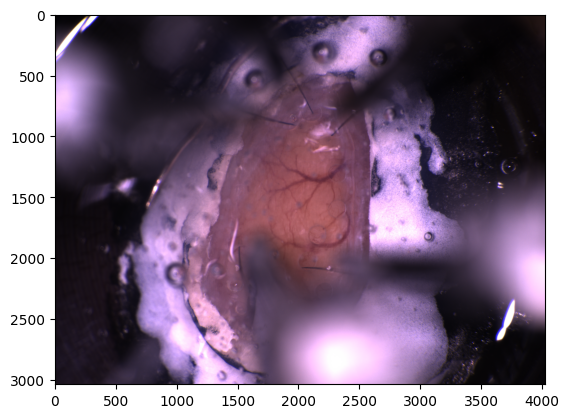

In [47]:
fig, ax = plt.subplots()
ax.imshow(surface_image)

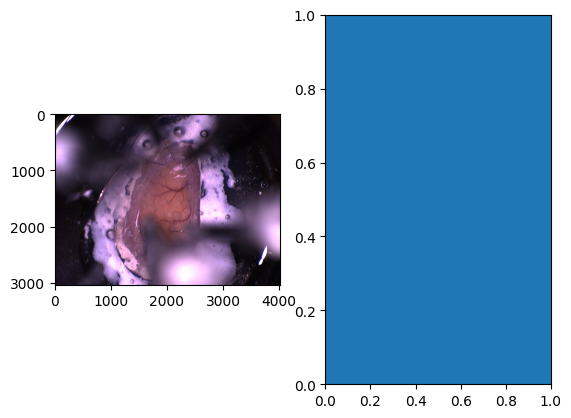

In [46]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(surface_image)
skunk.connect(ax[1], 'sk')
svg = skunk.insert({'sk': data})
skunk.display(svg)